In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Function to combine pickle files into a single DataFrame
def combine_pickles_with_class(path, class_name):
    acc_files = []
    gyro_files = []
    for file in os.listdir(path):
        if file.startswith(class_name) and file.endswith("_acc.pkl"):
            acc_files.append(file)
        elif file.startswith(class_name) and file.endswith("_gyro.pkl"):
            gyro_files.append(file)

    combined_data_list = []
    for i in range(len(acc_files)):
        acc_df = pd.read_pickle(path + acc_files[i])
        gyro_df = pd.read_pickle(path + gyro_files[i])
        if len(acc_df.columns) == 4:
            acc_df.drop(acc_df.columns[0], axis=1, inplace=True)
            gyro_df.drop(gyro_df.columns[0], axis=1, inplace=True)
        acc_df.columns = ["ax", "ay", "az"]
        gyro_df.columns = ["gx", "gy", "gz"]
        combined_df = pd.concat([acc_df, gyro_df], axis=1)
        combined_df["class"] = class_name
        combined_data_list.append(combined_df)

    final_df = pd.concat(combined_data_list, ignore_index=True)
    return final_df

In [4]:
# Combine and save train, valid, and test data for all classes
data_type = "train"
jump_data_cleaned = combine_pickles_with_class(f"clean_data/{data_type}/", "jump")
walk_data_cleaned = combine_pickles_with_class(f"clean_data/{data_type}/", "walk")
spain_data_cleaned = combine_pickles_with_class(f"clean_data/{data_type}/", "spain")
run_data_cleaned = combine_pickles_with_class(f"clean_data/{data_type}/", "run")

In [ ]:
# Save the combined data as pickle files
# jump_data_cleaned.to_pickle(f"clean_data/{data_type}/all_data_train.pkl")

In [5]:
# Function to clean NaN and infinite values
def clean_data(X_train, X_valid, X_test):
    X_train.fillna(X_train.mean(), inplace=True)
    X_valid.fillna(X_valid.mean(), inplace=True)
    X_test.fillna(X_test.mean(), inplace=True)
    return X_train, X_valid, X_test

In [6]:
# Load data
data_train = pd.read_pickle("clean_data/train/all_data_train.pkl")
data_valid = pd.read_pickle("clean_data/valid/all_data_valid.pkl")
data_test = pd.read_pickle("clean_data/test/all_data_test.pkl")

In [7]:
# Split the data into features (X) and target (y)
X_train = data_train.drop("class", axis=1)
X_valid = data_valid.drop("class", axis=1)
X_test = data_test.drop("class", axis=1)

y_train = data_train["class"]
y_valid = data_valid["class"]
y_test = data_test["class"]

In [8]:
# Encode the target variable
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_valid = encoder.transform(y_valid)
encoded_y_test = encoder.transform(y_test)

In [9]:
# Clean the data (replace NaNs and infinities)
X_train, X_valid, X_test = clean_data(X_train, X_valid, X_test)

In [10]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [11]:
# Define the first model (10 neurons per layer)
def create_model_10():
    model = Sequential()
    model.add(Dense(10, input_dim=6, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(4, activation="softmax"))
    model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model

In [12]:
# Define the second model (50 neurons per layer)
def create_model_50():
    model = Sequential()
    model.add(Dense(50, input_dim=6, activation="relu"))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(4, activation="softmax"))
    model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model

In [13]:
# Train the model with 10 neurons per layer
model_10 = create_model_10()
history_10 = model_10.fit(
    X_train,
    encoded_y_train,
    epochs=100,
    batch_size=10,
    validation_data=(X_valid, encoded_y_valid),
)

2024-10-06 01:32:12.167241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
1198/1198 [==============================] - 4s 2ms/step - loss: 0.9131 - accuracy: 0.6573 - val_loss: 0.5933 - val_accuracy: 0.7844
Epoch 2/100
1198/1198 [==============================] - 3s 2ms/step - loss: 0.5154 - accuracy: 0.8234 - val_loss: 0.3899 - val_accuracy: 0.8668
Epoch 3/100
1198/1198 [==============================] - 3s 2ms/step - loss: 0.4017 - accuracy: 0.8552 - val_loss: 0.3221 - val_accuracy: 0.8866
Epoch 4/100
1198/1198 [==============================] - 3s 2ms/step - loss: 0.3581 - accuracy: 0.8682 - val_loss: 0.2907 - val_accuracy: 0.8961
Epoch 5/100
1198/1198 [==============================] - 3s 2ms/step - loss: 0.3362 - accuracy: 0.8734 - val_loss: 0.2693 - val_accuracy: 0.9036
Epoch 6/100
1198/1198 [==============================] - 2s 2ms/step - loss: 0.3241 - accuracy: 0.8770 - val_loss: 0.2605 - val_accuracy: 0.9091
Epoch 7/100
1198/1198 [==============================] - 3s 2ms/step - loss: 0.3163 - accuracy: 0.8796 - val_loss: 0.2527 - val_ac

In [14]:
# Train the model with 50 neurons per layer
model_50 = create_model_50()
history_50 = model_50.fit(
    X_train,
    encoded_y_train,
    epochs=100,
    batch_size=10,
    validation_data=(X_valid, encoded_y_valid),
)

Epoch 1/100
1198/1198 [==============================] - 3s 2ms/step - loss: 0.4980 - accuracy: 0.8250 - val_loss: 0.2679 - val_accuracy: 0.9036
Epoch 2/100
1198/1198 [==============================] - 2s 2ms/step - loss: 0.2827 - accuracy: 0.8930 - val_loss: 0.2258 - val_accuracy: 0.9169
Epoch 3/100
1198/1198 [==============================] - 3s 3ms/step - loss: 0.2462 - accuracy: 0.9058 - val_loss: 0.2175 - val_accuracy: 0.9179
Epoch 4/100
1198/1198 [==============================] - 3s 2ms/step - loss: 0.2248 - accuracy: 0.9144 - val_loss: 0.2052 - val_accuracy: 0.9244
Epoch 5/100
1198/1198 [==============================] - 3s 2ms/step - loss: 0.2120 - accuracy: 0.9219 - val_loss: 0.1958 - val_accuracy: 0.9271
Epoch 6/100
1198/1198 [==============================] - 3s 2ms/step - loss: 0.2007 - accuracy: 0.9247 - val_loss: 0.2063 - val_accuracy: 0.9244
Epoch 7/100
1198/1198 [==============================] - 3s 3ms/step - loss: 0.1931 - accuracy: 0.9275 - val_loss: 0.1950 - val_ac

In [15]:
# Evaluate both models on the test set
print("\nEvaluating Model with 10 Neurons:")
test_loss_10, test_accuracy_10 = model_10.evaluate(X_test, encoded_y_test)
print(f"Model 10 Neurons - Test Accuracy: {test_accuracy_10 * 100:.2f}%")

print("\nEvaluating Model with 50 Neurons:")
test_loss_50, test_accuracy_50 = model_50.evaluate(X_test, encoded_y_test)
print(f"Model 50 Neurons - Test Accuracy: {test_accuracy_50 * 100:.2f}%")


Evaluating Model with 10 Neurons:
125/125 [==============================] - 0s 2ms/step - loss: 0.2365 - accuracy: 0.9228
Model 10 Neurons - Test Accuracy: 92.28%

Evaluating Model with 50 Neurons:
125/125 [==============================] - 0s 2ms/step - loss: 0.3648 - accuracy: 0.9228
Model 50 Neurons - Test Accuracy: 92.28%


In [16]:
# Function to plot accuracy and loss
def plot_history(history, model_name):
    plt.figure(figsize=(14, 5))
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title(f"{model_name} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(f"{model_name} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

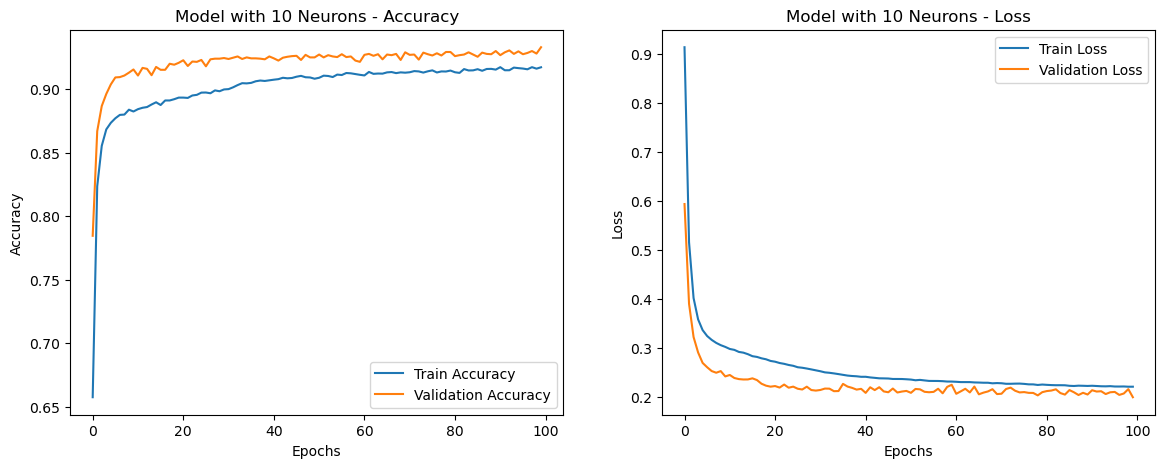

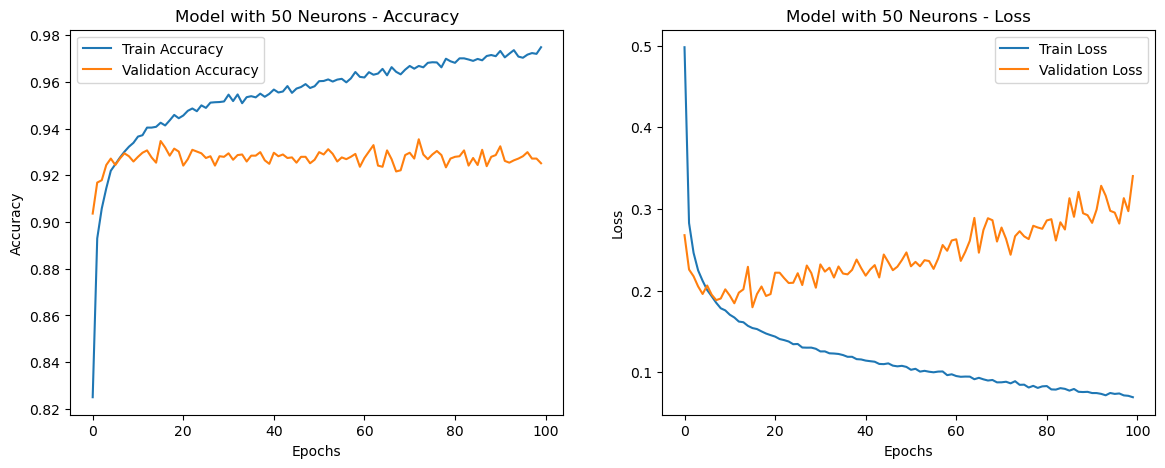

In [17]:
# Plot training history for both models
plot_history(history_10, "Model with 10 Neurons")
plot_history(history_50, "Model with 50 Neurons")

125/125 [==============================] - 0s 2ms/step


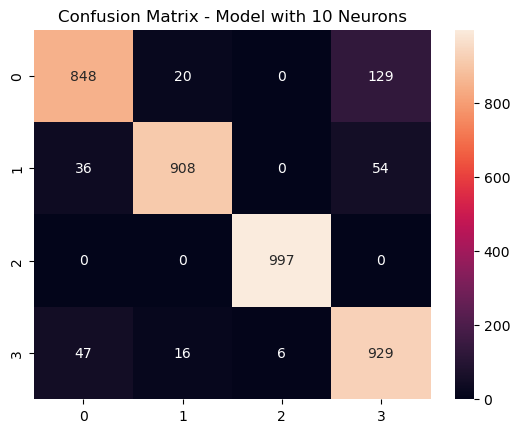

In [18]:
# Predict and calculate confusion matrix for Model with 10 Neurons
y_pred_10 = model_10.predict(X_test)
y_pred_classes_10 = np.argmax(y_pred_10, axis=1)
conf_matrix_10 = confusion_matrix(encoded_y_test, y_pred_classes_10)
sns.heatmap(conf_matrix_10, annot=True, fmt="d")
plt.title("Confusion Matrix - Model with 10 Neurons")
plt.show()

125/125 [==============================] - 0s 2ms/step


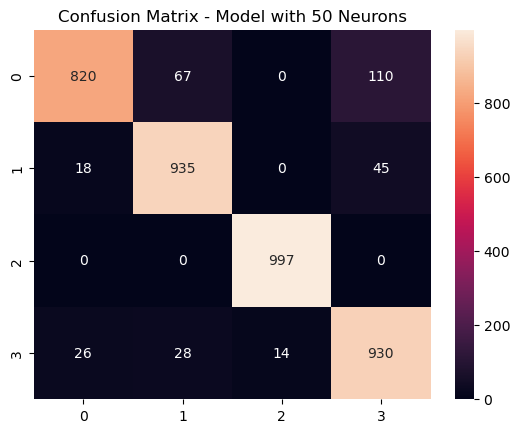

In [19]:
# Predict and calculate confusion matrix for Model with 50 Neurons
y_pred_50 = model_50.predict(X_test)
y_pred_classes_50 = np.argmax(y_pred_50, axis=1)
conf_matrix_50 = confusion_matrix(encoded_y_test, y_pred_classes_50)
sns.heatmap(conf_matrix_50, annot=True, fmt="d")
plt.title("Confusion Matrix - Model with 50 Neurons")
plt.show()